##### 🗂️ **`Project Contents`**
* **Summary: Customer Churn Prediction with Logistic Regression and XGBoost**
    *  Built robust classification pipelines using scikit-learn with preprocessing (StandardScaler, OneHotEncoder, OrdinalEncoder), L1-based feature selection, and modeling.
    *  Trained and evaluated both Logistic Regression and XGBoost using 5-fold Stratified Cross-Validation.
    *  Achieved XGBoost Accuracy: ~XX%, ROC AUC: ~YY on test set.
    *  Developed detailed EDA and model evaluation reports including ROC curves, feature importances, and confusion matrices.
    *  Tools: pandas, scikit-learn, xgboost, matplotlib, seaborn
    * **ROC Curve (Receiver Operating Characteristic Curve)**
* **Logistic Regression** is a **classification algorithm** used to predict probability of a **binary** outcome (like Yes/No, 0/1, True/False).
* **XtremeGradientBoostClassifier:** classification model based on gradient boosting decision trees
    * **Penalties** are used to prevent overfitting by discouraging complex models (like large coefficients).
        * L1 - Adds **absolute value** of weights to loss, L2 - Adds **squared value** of weights to loss
    * **Solvers** are **optimization algorithms** used to find best model parameters (like weights) by minimizing loss function.
    * **Loss function** measures how far off a model's predictions are from actual values.
        * logloss/cross-entropy:  difference between the **actual label** and **predicted probability**
        * Cross-Entropy is just a general term (used in multi-class too), while Log Loss often refers to the binary case
    * **Gradient Descent** optimization algorithm used to minimize loss function by updating model parameters
    * **Model parameters** are internal values a machine learning model learns from training data
---

* **CSV File:** **`Customer-Churn.csv`**
* **Columns:**

| Column Name        | Description                                                       |
| ------------------ | ----------------------------------------------------------------- |
| `customerID`       | Unique identifier for each customer                               |
| `gender`           | Customer gender (`Male` or `Female`)                              |
| `SeniorCitizen`    | Indicates if the customer is a senior (1 = Yes, 0 = No)           |
| `Partner`          | Whether the customer has a partner (`Yes` or `No`)                |
| `Dependents`       | Whether the customer has dependents (`Yes` or `No`)               |
| `tenure`           | Number of months the customer has stayed with the company         |
| `PhoneService`     | Whether the customer has phone service (`Yes` or `No`)            |
| `MultipleLines`    | Whether the customer has multiple phone lines                     |
| `InternetService`  | Type of internet service (`DSL`, `Fiber optic`, `No`)             |
| `OnlineSecurity`   | Whether the customer has online security service                  |
| `OnlineBackup`     | Whether the customer has online backup service                    |
| `DeviceProtection` | Whether the customer has device protection service                |
| `TechSupport`      | Whether the customer has tech support service                     |
| `StreamingTV`      | Whether the customer has streaming TV service                     |
| `StreamingMovies`  | Whether the customer has streaming movies service                 |
| `Contract`         | Type of contract (`Month-to-month`, `One year`, `Two year`)       |
| `PaperlessBilling` | Whether the customer uses paperless billing (`Yes` or `No`)       |
| `PaymentMethod`    | Payment method (e.g., `Electronic check`, `Mailed check`, etc.)   |
| `MonthlyCharges`   | The amount charged to the customer monthly                        |
| `TotalCharges`     | Total amount charged (may need to convert from object to numeric) |
| `Churn`            | Whether the customer has left the company (`Yes` or `No`)         |
---


##### 📊 **Classification Metrics Summary**
| Metric     | Means                                                                 | Formula                                              | Best When                                               |
|------------|-----------------------------------------------------------------------|------------------------------------------------------|----------------------------------------------------------|
| Accuracy   | Overall, how many predictions were correct?                           | (TP + TN) / (TP + TN + FP + FN)                      | Classes are balanced and all errors matter equally.      |
| Precision  | Of all predicted positives, how many were actually positive?          | TP / (TP + FP)                                       | False positives are costly (e.g., flagging good emails). |
| Recall     | Of all actual positives, how many did we correctly predict?           | TP / (TP + FN)                                       | False negatives are costly (e.g., missing cancer cases). |
| F1 Score   | Balance between Precision and Recall                                  | 2 * (Precision * Recall) / (Precision + Recall)      | You need a balance and classes are imbalanced.           |

##### 🛠️ **How to Improve These Metrics**
| Technique                      | Helps Improve                          |
|-------------------------------|----------------------------------------|
| ✅ Tune classification threshold | Precision or Recall (adjust trade-off) |
| ✅ Use better features          | All metrics                            |
| ✅ Try different models         | All metrics                            |
| ✅ Resampling (SMOTE, etc.)     | Recall (especially for imbalanced data)|
| ✅ Class weighting              | Precision, Recall, F1 Score             |


In [1]:
# Using PIPELINE: Built classification models to predict customer churn using logistic regression and XGBoost
# e.g. Customer-Churn.csv
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("data/Customer-Churn.csv")

# Clean TotalCharges
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(0)

# Drop customerID
df.drop("customerID", axis=1, inplace=True)

# Encode target
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})
y = df["Churn"]

# Define ordinal features (with a meaningful order)
ordinal_features = ["Contract"]
ordinal_mapping = [["Month-to-month", "One year", "Two year"]]  # low to high commitment

# All categorical features
cat_cols = df.select_dtypes(include="object").columns.tolist()

# Identify nominal (non-ordinal) features
nominal_features = [col for col in cat_cols if col not in ordinal_features]

# Numerical columns
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
num_cols.remove("Churn")

# Column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("ord", OrdinalEncoder(categories=ordinal_mapping), ordinal_features),
        ("nom", OneHotEncoder(drop="first", handle_unknown="ignore"), nominal_features),
    ]
)

# Logistic Regression pipeline with feature selection
lr_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "feature_selection",
            SelectFromModel(
                LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000)
            ),
        ),
        ("classifier", LogisticRegression(max_iter=1000)),
    ]
)

# XGBoost pipeline (with same preprocessor and feature selection)
xgb_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "feature_selection",
            SelectFromModel(
                LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000)
            ),
        ),
        (
            "classifier",
            XGBClassifier(eval_metric="logloss", random_state=42),
        ),
    ]
)

# Stratified K-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate Logistic Regression
lr_scores = cross_val_score(lr_pipeline, df, y, cv=cv, scoring="accuracy")
print(
    f"Logistic Regression CV Accuracy: {lr_scores.mean():.4f} ± {lr_scores.std():.4f}"
)

# Evaluate XGBoost
xgb_scores = cross_val_score(xgb_pipeline, df, y, cv=cv, scoring="accuracy")
print(f"XGBoost CV Accuracy: {xgb_scores.mean():.4f} ± {xgb_scores.std():.4f}")

X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.25, stratify=y, random_state=42
)

xgb_pipeline.fit(X_train, y_train)
y_pred = xgb_pipeline.predict(X_test)
y_prob = xgb_pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Logistic Regression CV Accuracy: 0.8051 ± 0.0103
XGBoost CV Accuracy: 0.7876 ± 0.0109
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1294
           1       0.60      0.51      0.55       467

    accuracy                           0.78      1761
   macro avg       0.72      0.69      0.70      1761
weighted avg       0.77      0.78      0.77      1761

ROC AUC: 0.823720250604834


---
#### **`EDA Dashboards`**
---

##### **Target Distribution**

<Axes: title={'center': 'Churn Distribution'}, xlabel='Churn'>

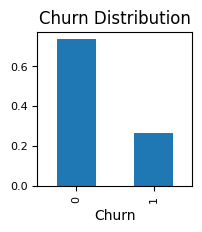

In [15]:
df["Churn"].value_counts(normalize=True).plot(
    kind="bar", title="Churn Distribution", figsize=(2, 2), fontsize=8
)

##### **Numerical Feature Histograms**

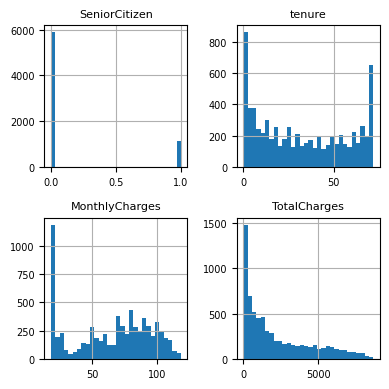

In [23]:
axes = df[num_cols].hist(bins=30, figsize=(4, 4), xlabelsize=7, ylabelsize=7)
# Loop through each subplot and set the title font size
for ax in axes.flatten():
    ax.title.set_fontsize(8)  # change 10 to whatever size you prefer
plt.tight_layout()
plt.show()

##### **Correlation Heatmap**

<Axes: >

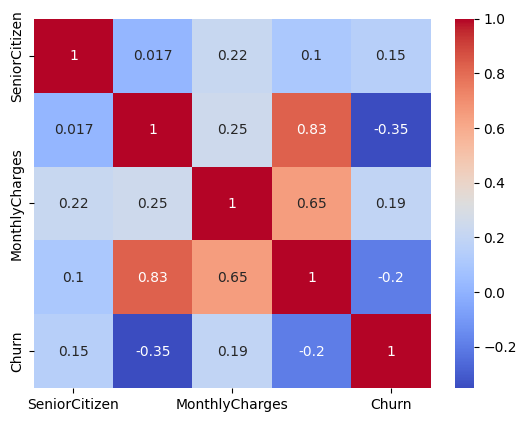

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(
    df[num_cols + ["Churn"]].corr(),
    annot=True,
    cmap="coolwarm",
    xticklabels=2,
    yticklabels=2,
)

##### **Churn vs Categorical Features (Bar plots)**

In [18]:
# for col in nominal_features + ordinal_features:
# pd.crosstab(df[col], df["Churn"], normalize="index").plot(kind="bar", stacked=True)
# plt.title(f"Churn Rate by {col}")
# plt.ylabel("Proportion")
# plt.show()

#### **📉 `Model Evaluation Dashboard`**

##### **ROC Curve (Receiver Operating Characteristic Curve)**
    - The ROC AUC(Area Under Curve) curve is a performance measurement for classification models, especially binary classifiers. 
    - It helps evaluate how well a model distinguishes between two classes (typically positive and negative).

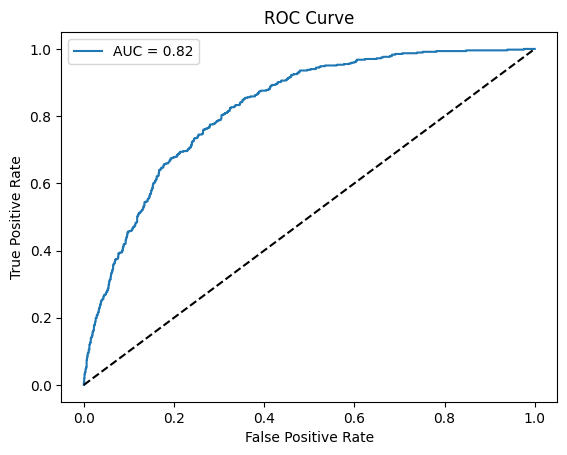

In [19]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

##### **Confusion Matrix**

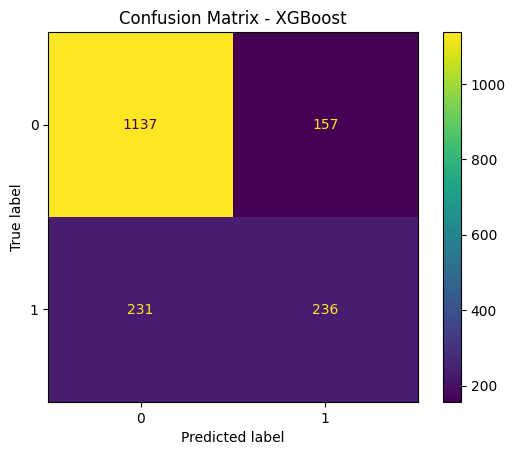

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(xgb_pipeline, X_test, y_test)
plt.title("Confusion Matrix - XGBoost")
plt.show()

##### **Feature Importance (from XGBoost)**

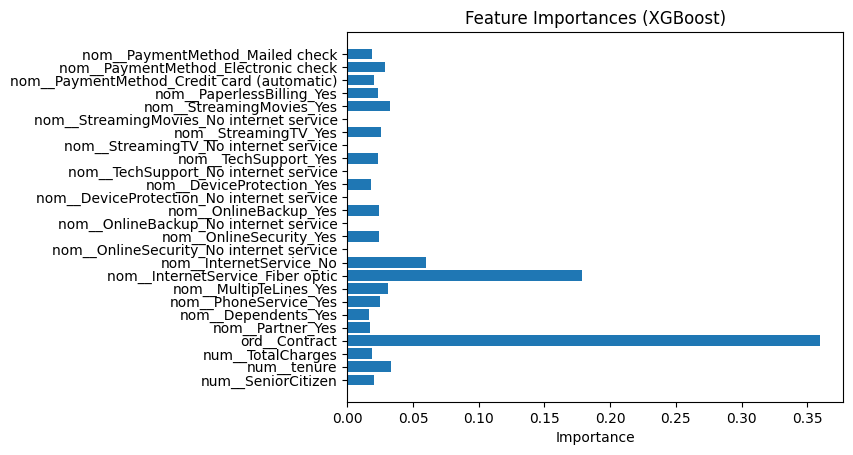

In [21]:
import matplotlib.pyplot as plt

xgb_model = xgb_pipeline.named_steps["classifier"]
importances = xgb_model.feature_importances_

# Get feature names from preprocessor
feature_names = xgb_pipeline.named_steps["preprocessor"].get_feature_names_out()
selected_features = xgb_pipeline.named_steps["feature_selection"].get_support()

# Map selected feature importances
selected_names = feature_names[selected_features]
plt.barh(selected_names, importances)
plt.title("Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.show()